# Overview
1. Announcements
2. Warm up
3. Work on a regression model
4. Learn about PDP and SHAP plots
5. Talk about project module and SC

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**

# I. Wrangle Data

In [ ]:
def wrangle(df):

  filepath = DATA_PATH+'lending-club/lending-club-subset.csv'

  df = pd.read_csv(filepath,parse_dates=['issue_d'],index_col='issue_d',skipinitialspace=True).sort_index()

  # Consider only data with 36 month term period
  df = df[df['term']=='36 months']
  df.drop(columns='term',inplace=True)

  # Reg-X Expression - Concolidate values in your feature into categories
  keywords= ['business','consolidation|credit','home','car|vacation|medical|moving']
  for col in keywords:
    df[col] = df['title'].fillna('').str.lower().str.contains(col,regex=True).astype(int)

  # drop title column since it was used in feature engineering
  df.drop(columns='title',inplace=True)

  # Columns that we will retain for our model (cherry picking for demonstration)
  cols_to_keep = keywords + ['int_rate','fico_range_high','funded_amnt','annual_inc']

  df=df[cols_to_keep]

  #Clean up interest rate columns
  df['int_rate'] = df['int_rate'].str.strip('%').astype(float)

  # Renaming certian columns for eas of use in our model building
  df.rename(columns={'consolidation|credit':'consolidation','car|vacation|medical|moving':'personal'},inplace=True)
  
  return df

In [ ]:
df = wrangle(DATA_PATH+'lending-club/lending-club-subset.csv')

In [ ]:
round((df.isnull().sum()/len(df)*100),2)

business           0.0
consolidation      0.0
home               0.0
personal           0.0
int_rate           0.0
fico_range_high    0.0
funded_amnt        0.0
annual_inc         0.0
dtype: float64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102996 entries, 2007-07-01 to 2019-03-01
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   business         102996 non-null  int64  
 1   consolidation    102996 non-null  int64  
 2   home             102996 non-null  int64  
 3   personal         102996 non-null  int64  
 4   int_rate         102996 non-null  float64
 5   fico_range_high  102996 non-null  float64
 6   funded_amnt      102996 non-null  float64
 7   annual_inc       102996 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 7.1 MB


# II. Split Data

In [ ]:
# Sharply plots do NOT Take pipelines

In [ ]:
# Split into FM and TV
target = 'int_rate'
X,y=df.drop(columns=target),df[target]

In [ ]:
X.shape

(102996, 7)

In [ ]:
# TRAIN ON THE PAST TRAIN ON THE FUTURE WHEN TIME SERIES

In [ ]:
#Split into train, val, and test data
X_train,y_train = X.head(70000),y[:70000]
X_val,y_val = X[70000:85000],y[70000:85000]
X_test,y_test = X[85000:102996],y[85000:102996]

# III. Establish Baseline

In [ ]:
y_pred_bl = [y_train.mean()]*len(y_train)
print('Mean interest Rate',y_train.mean())
print('Baseline MAE',mean_absolute_error(y_train,y_pred_bl))

Mean interest Rate 11.48878628571345
Baseline MAE 2.9048040458449176


# IV. Build Model

In [ ]:
model_r = Ridge()
model_rfr = RandomForestRegressor() # You can specify max_depth, random_state, and all the hyper parameters you want to tweak
model_xgbr = XGBRegressor()

In [ ]:
model_r.fit(X_train,y_train)
model_rfr.fit(X_train,y_train)
model_xgbr.fit(X_train,y_train)

[17:16:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

# V. Check Metrics

In [ ]:
def check_metrics(model):
  print(model)
  print('Training MAE:',mean_absolute_error(y_train,model.predict(X_train)))
  print('Validation MAE:',mean_absolute_error(y_val,model.predict(X_val)))
  print('R2 Score',model.score(X_val,y_val))

model=[model_r,model_rfr,model_xgbr]
for m in model:
  check_metrics(m)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Training MAE: 2.3602033410069514
Validation MAE: 2.6155961120515316
R2 Score 0.1644921019421005
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Training MAE: 1.1006093771759284
Validation MAE: 2.7246740459523435
R2 Score 0.08940731873491291
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_r

# VI. Communicate Results

## Partial Dependence Plots

One Feature

In [ ]:
X_val.columns

Index(['business', 'consolidation', 'home', 'personal', 'fico_range_high',
       'funded_amnt', 'annual_inc'],
      dtype='object')

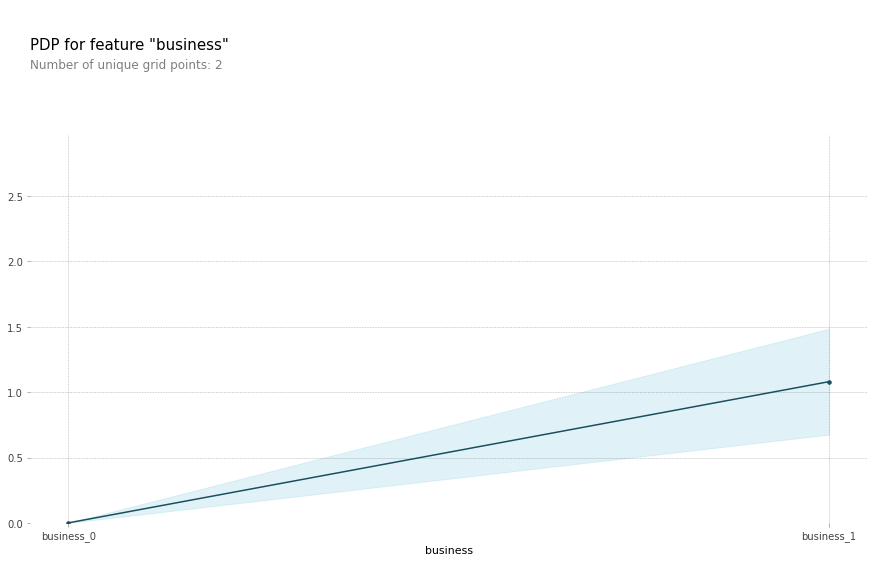

In [ ]:
isolate = pdp_isolate(model_xgbr, dataset = X_val,
                      model_features = X_val.columns,
                      feature = 'business')

pdp_plot(isolate,feature_name='business');

Two features

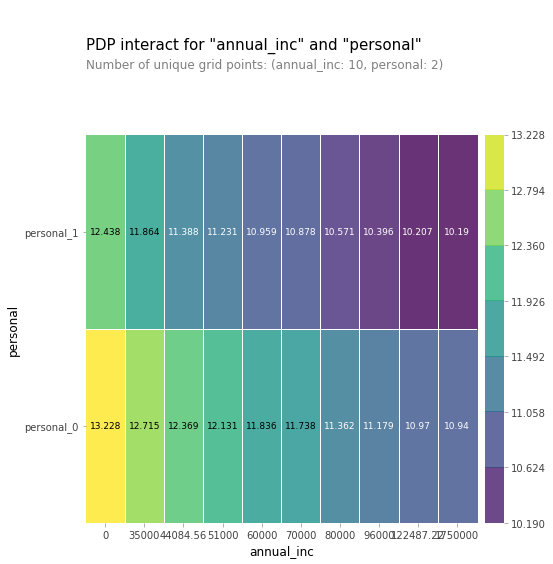

In [ ]:
features = ['annual_inc','personal']
interact=pdp_interact(model_xgbr,dataset=X_val,model_features=X_val.columns,features=features)
pdp_interact_plot(interact,plot_type='grid',feature_names=features);

## Shapley Plots

- Show you the influence of features in *individual* predictions.

In [ ]:
import shap

In [ ]:
# Sharpley allows you to visualize the prediciton decision at the sample level. So take one sample as and example to view the decisions
samp = X_val.head(2)

In [ ]:
explainer = shap.TreeExplainer(model_xgbr)
shap_values = explainer.shap_values(samp)

shap.initjs()
shap.force_plot(base_value = explainer.expected_value,
                shap_values=shap_values,
                features=samp)

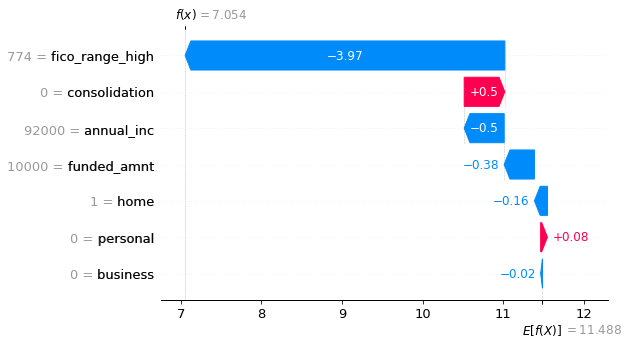

In [ ]:
explainer = shap.TreeExplainer(model_xgbr)
shap_values=explainer(X_val)
shap.plots.waterfall(shap_values[0])